In [33]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('default', category=ConvergenceWarning)

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [4]:
# HIDDEN
df = pd.read_csv('water_large.csv')

In [22]:
# HIDDEN
from collections import namedtuple
Curve = namedtuple('Curve', ['xs', 'ys'])

def flatten(seq): return [item for subseq in seq for item in subseq]

def make_curve(clf, x_start=-50, x_end=50):
    xs = np.linspace(x_start, x_end, num=100)
    ys = clf.predict(xs.reshape(-1, 1))
    return Curve(xs, ys)

def plot_data(df=df, ax=plt, **kwargs):
    ax.scatter(df.iloc[:, 0], df.iloc[:, 1], s=50, **kwargs)

def plot_curve(curve, ax=plt, **kwargs):
    ax.plot(curve.xs, curve.ys, **kwargs)
    
def plot_curves(curves, cols=2, labels=None):
    if labels is None:
        labels = [f'Deg {deg} poly' for deg in degrees]
    rows = int(np.ceil(len(curves) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8),
                             sharex=True, sharey=True)
    for ax, curve, label in zip(flatten(axes), curves, labels):
        plot_data(ax=ax, label='Training data')
        plot_curve(curve, ax=ax, label=label)
        ax.set_ylim(-5e10, 170e10)
        ax.legend()
        
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off',
                    left='off', right='off')
    plt.grid(False)
    plt.title('Polynomial Regression')
    plt.xlabel('Water Level Change (m)')
    plt.ylabel('Water Flow (Liters)')
    plt.tight_layout()

In [23]:
# HIDDEN
def coefs(clf):
    reg = clf.named_steps['reg']
    return np.append(reg.intercept_, reg.coef_)

def coef_table(clf):
    vals = coefs(clf)
    return (pd.DataFrame({'Coefficient Value': vals})
            .rename_axis('degree'))

In [120]:
# HIDDEN
X = df.iloc[:, [0]].as_matrix()
y = df.iloc[:, 1].as_matrix()

degrees = [1, 2, 8, 12]
clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                  ('reg', LinearRegression())])
        .fit(X, y)
        for deg in degrees]

curves = [make_curve(clf) for clf in clfs]

alphas = [0.1, 1.0, 10.0]

ridge_clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                        ('reg', RidgeCV(alphas=alphas, normalize=True))])
        .fit(X, y)
        for deg in degrees]

ridge_curves = [make_curve(clf) for clf in ridge_clfs]

lasso_clfs = [Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                        ('reg', LassoCV(normalize=True, precompute=True, tol=0.001))])
        .fit(X, y)
        for deg in degrees]
lasso_curves = [make_curve(clf) for clf in lasso_clfs]

## L1 Regularization: Lasso Regression

In this section we introduce $ L_1 $ regularization, another regularization technique that is useful for feature selection.

We start with a brief review of $ L_2 $ regularization for linear regression. We use the model:

$$
f_\hat{\theta}(x) = \hat{\theta} \cdot x
$$

We fit the model by minimizing the mean squared error cost function with an additional regularization term:

$$
\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}(y_i - f_\hat{\theta} (X_i))^2
    + \lambda \sum_{j = 1}^{p} \hat{\theta_j}^2
\end{aligned}
$$

In the above definitions, $ X $ represents the $ n \times p $ data matrix, $ x $ represents a row of $ X $, $ y $ represents the observed outcomes, $ \hat{\theta} $ represents the model weights, and $ \lambda $ represents the regularization parameter.

## L1 Regularization Definition

To add $ L_1 $ regularization to the model, we modify the cost function above:

$$
\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}(y_i - f_\hat{\theta} (X_i))^2
    + \lambda \sum_{j = 1}^{p} |\hat{\theta_j}|
\end{aligned}
$$

Observe that the two cost functions only differ in their regularization term. $ L_1 $ regularization penalizes the sum of the absolute weight values instead of the sum of squared values.

Using $ L_1 $ regularization with a linear model and the mean squared error cost function is also known more commonly as **lasso regression**. (Lasso stands for Least Absolute Shrinkage and Selection Operator.)

## Comparing Lasso and Ridge Regression

To conduct lasso regression, we make use of `scikit-learn`'s convenient [`LassoCV`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) classifier, a version of the [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) classifier that performs cross-validation to select the regularization parameter. Below, we display our dataset of water level change and water flow out of a dam.

In [124]:
# HIDDEN
df

,water_level_change,water_flow
0,-15.94,60422330445.52
1,-29.15,33214896575.60
2,36.19,972706380901.06
...,...,...
20,7.09,236352046523.78
21,46.28,1494256381086.73
22,14.61,378146284247.97


Since the procedure is almost identical to using the `RidgeCV` classifier from the previous section, we omit the code and instead display the base degree 12 polynomial, ridge regression, and lasso regression model predictions below.

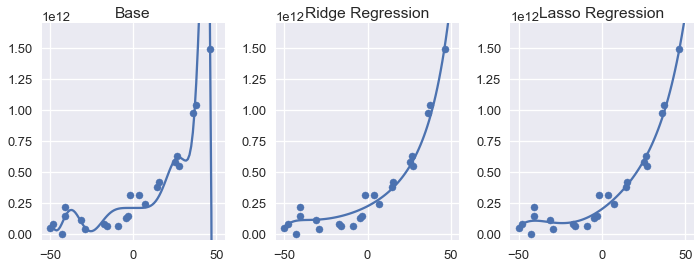

In [125]:
# HIDDEN
fig = plt.figure(figsize=(10, 4))

plt.subplot(131)
plot_data()
plot_curve(curves[3])
plt.title('Base')
plt.ylim(-5e10, 170e10)

plt.subplot(132)
plot_data()
plot_curve(ridge_curves[3])
plt.title('Ridge Regression')
plt.ylim(-5e10, 170e10)

plt.subplot(133)
plot_data()
plot_curve(lasso_curves[3])
plt.title('Lasso Regression')
plt.ylim(-5e10, 170e10)
plt.tight_layout()

We can see that both regularized models have less variance than the base degree 12 polynomial. At a glance, it appears that using $ L_2 $ and $ L_1 $ regularization produces nearly identical models. Comparing the coefficients of ridge and lasso regression, however, reveals the most significant difference between the two types of regularization: the lasso regression model sets a number of model weights to zero.

In [135]:
# HIDDEN
ridge = coef_table(ridge_clfs[3]).rename(columns={'Coefficient Value': 'Ridge'})
lasso = coef_table(lasso_clfs[3]).rename(columns={'Coefficient Value': 'Lasso'})

pd.options.display.max_rows = 20
pd.set_option('display.float_format', '{:.10f}'.format)
display(ridge.join(lasso))
pd.options.display.max_rows = 7
pd.set_option('display.float_format', '{:.2f}'.format)

,Ridge,Lasso
degree,,
0,221303288116.2275085449,198212062407.2835693359
1,6953405307.7653837204,9655088668.0876655579
2,142621063.9297277331,198852674.1646585464
3,1893283.0567885502,0.0000000000
4,38202.1520293704,34434.3458919188
5,484.4262914111,975.6965959434
6,8.1525126516,0.0000000000
7,0.1197232472,0.0887942172
8,0.0012506185,0.0000000000


If you will forgive the verbose output above, you will notice that ridge regression results in non-zero weights for the all polynomial features. Lasso regression, on the other hand, produces weights of zero for seven features.

In other words, the lasso regression model completely tosses out a majority of the features when making predictions. Nonetheless, the plots above show that the lasso regression model will make nearly identical predictions compared to the ridge regression model.

## Feature Selection with Lasso Regression

Lasso regression performs **feature selection**—it discards a subset of the original features when fitting model parameters. This is particularly useful when working with high-dimensional data with many features. A model that only uses a few features to make a prediction will run much faster than a model that requires many calculations. Since unneeded features tend to increase model variance without decreasing bias, we can sometimes increase the accuracy of other models by using lasso regression to select a subset of features to use.

## Lasso vs. Ridge In Practice

If our goal is merely to achieve the highest prediction accuracy, we can try both types of regularization and use cross-validation to select between the two types.

Sometimes we prefer one type of regularization over the other because it maps more closely to the domain we are working with. For example, if know that the phenomenon we are trying to model results from many small factors, we might prefer ridge regression because it won't discard these factors. On the other hand, some outcomes result from a few highly influential features. We prefer lasso regression in these situations because it will discard unneeded features.

Lasso regression models tend to take more computation to fit than ridge regression models which may also be a concern depending on your data and your available computational resources.

## Summary

Using $ L_1 $ regularization, like $ L_2 $ regularization, allows us to tune model bias and variance by penalizing large model weights. $ L_1 $ regularization for least squares linear regression is also known by the more common name lasso regression. Lasso regression may also be used to perform feature selection since it discards insignificant features.